# Find Noisy Nodes in Graph without Edges

#### Features:
  - Graph : `[0]`
  - Node  : `[x, y] + [0, 1, 1, 1, 0, 0]` i.e. coordinate + layers
  
#### Labels:
  - Graph : $\left[\frac{\# \text{ Noisy Nodes}}{\# \text{ Nodes}}\right]$
  - Node  : `[0, 1]` for noisy and `[1, 0]` for **NOT** noisy

In [1]:
PATH_PREFIX = '../'
DATA_DIR = 'D0toPiKInAcceptanceSignal_Iteration1_Parsed/'
MODEL_SAVE_DIR = 'Model(Noise)/'

import sys
sys.path.append(PATH_PREFIX)

DATA_FILE_PATH = PATH_PREFIX + DATA_DIR + 'dataset_{:04d}.json'

In [2]:
#@title Imports

from __future__ import absolute_import, division, print_function

from graphGenerator import to_graph_dict_without_edges

import collections
import ujson
import time

from graph_nets import utils_np, utils_tf
import modelNoise as model

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

In [3]:
#@title Helper functions


def get_node_pos(graph):
    return {k: np.array([v['features'][0], v['features'][1]]) for k, v in graph.node.items()}


def generate_dict_graphs(raw_data, offset, batch_size):
    """Generate graphs for training.
    
    Args:
        raw_data: The list of raw data objects.
        offset: Starting index to pick from the `raw_data`.
        batch_size: Total number of graphs per batch.
        
    Returns:
        input_graph_dict: An input graph in dictionary format.
        target_graph_dict: A labelled input graph in dictionary format.
    """
    input_graphs = []
    target_graphs = []
    for i in range(offset, offset + batch_size):        
        input_graph_dict, target_graph_dict = to_graph_dict_without_edges(raw_data[i])
        input_graphs.append(input_graph_dict)
        target_graphs.append(target_graph_dict)
    return input_graphs, target_graphs


def create_placeholders(raw_data, offset, batch_size):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.

  Returns:
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
  """
    # Create some example data for inspecting the vector sizes.
    input_graphs, target_graphs = generate_dict_graphs(raw_data, offset, batch_size)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs)

    return input_ph, target_ph


def create_feed_dict(raw_data, offset, batch_size, input_ph, target_ph):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.

  Returns:
    feed_dict: The feed `dict` of input and target placeholders and data.
    raw_graphs: The `dict` of raw networkx graphs.
  """
    inputs, targets = generate_dict_graphs(raw_data, offset, batch_size)
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs)
    target_graphs = utils_np.data_dicts_to_graphs_tuple(targets)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}

    return feed_dict


def compute_accuracy(target,
                     output,
                     use_only_noisy=False):
    """Calculate model accuracy.

  Returns the number of correctly predicted noisy nodes and the number
  of completely solved graphs (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graphs.
    output: A `graphs.GraphsTuple` that contains the output graphs.
    use_only_noisy: A `bool` indicator of whether to consider
                    only noisy nodes for computing accuracy or not.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
  """
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)
        c = []
        if use_only_noisy:
            c.append((xn == yn)[xn > 0])
        else:
            c.append(xn == yn)
        c = np.concatenate(c, axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))
    return correct, solved


def create_loss_ops(target_op, output_ops):
    loss_ops = [
        tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes)
        for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


class GraphPlotter(object):
    def __init__(self, ax, graph, pos):
        self._ax = ax
        self._graph = graph
        self._pos = pos
        self._base_draw_kwargs = dict(G=self._graph,
                                      pos=self._pos,
                                      ax=self._ax)
        self._nodes = None
        self._noisy_nodes = None
        self._noisy_nodes_count = None
        self._ax.set_axis_off()

    @property
    def noisy_nodes_count(self):
        if self._noisy_nodes_count is None:
            self._noisy_nodes_count = len(self.noisy_nodes)
        return self._noisy_nodes_count

    @property
    def nodes(self):
        if self._nodes is None:
            self._nodes = self._graph.nodes()
        return self._nodes

    @property
    def noisy_nodes(self):
        if self._noisy_nodes is None:
            self._noisy_nodes = [
                n for n in self.nodes
                if np.all(self._graph.node[n].get('features') == np.array([0, 1]).astype(float))
            ]
        return self._noisy_nodes

    def _make_draw_kwargs(self, **kwargs):
        kwargs.update(self._base_draw_kwargs)
        return kwargs

    def _draw(self, draw_function, zorder=None, **kwargs):
        draw_kwargs = self._make_draw_kwargs(**kwargs)
        collection = draw_function(**draw_kwargs)
        if collection is not None and zorder is not None:
            try:
                # This is for compatibility with older matplotlib.
                collection.set_zorder(zorder)
            except AttributeError:
                # This is for compatibility with newer matplotlib.
                collection[0].set_zorder(zorder)
        return collection

    def draw_nodes(self, **kwargs):
        """Useful kwargs: nodelist, node_size, node_color, linewidths."""
        if ("node_color" in kwargs
                and isinstance(kwargs["node_color"], collections.Sequence)
                and len(kwargs["node_color"]) in {3, 4}
                and not isinstance(kwargs["node_color"][0],
                                   (collections.Sequence, np.ndarray))):
            num_nodes = len(kwargs.get("nodelist", self.nodes))
            kwargs["node_color"] = np.tile(
                np.array(kwargs["node_color"])[None], [num_nodes, 1])
        return self._draw(nx.draw_networkx_nodes, **kwargs)

    def draw_graph_with_noise(self,
                              node_size=40,
                              node_color=(1.0, 1.0, 1.0),
                              noisy_node_color=(1.0, 0.0, 0.0),
                              node_linewidth=1.0,
                              draw_noisy_nodes=True):
        node_border_color = (0.0, 0.0, 0.0, 1.0)
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.nodes]
        else:
            c = node_color
        # Plot nodes.
        self.draw_nodes(nodelist=self.nodes,
                        node_size=node_size,
                        node_color=c,
                        linewidths=node_linewidth,
                        edgecolors=node_border_color,
                        zorder=20)
        # Plot noisy nodes.
        if draw_noisy_nodes:
            self.draw_nodes(nodelist=self.noisy_nodes,
                            node_size=node_size,
                            node_color=noisy_node_color,
                            linewidths=node_linewidth,
                            edgecolors=node_border_color,
                            zorder=30)
        self._ax.set_title("Total noisy nodes: {}".format(self.noisy_nodes_count))

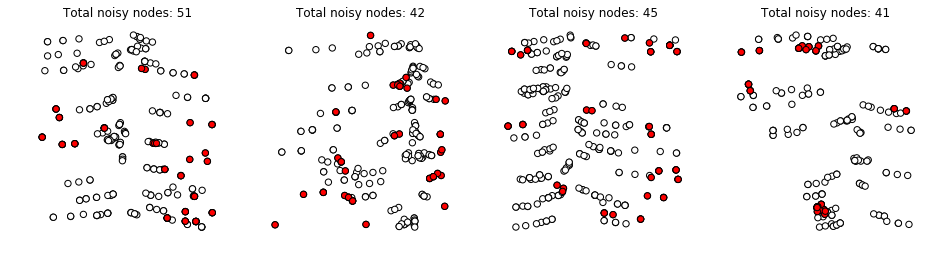

In [4]:
#@title Visualize example graphs

DATA_FILE_NUMBER = 1
num_examples = 4


data_file = open(DATA_FILE_PATH.format(DATA_FILE_NUMBER), 'r')
input_raw_data = ujson.loads(data_file.read())
data_file.close()

input_ph, target_ph = create_placeholders(input_raw_data, 0, num_examples)
feed_dict = create_feed_dict(input_raw_data, 0, num_examples, input_ph, target_ph)
input_graphs_tuple, target_graphs_tuple = feed_dict[input_ph], feed_dict[target_ph]

# We can visualize the graph using networkx.
input_graphs_nx = utils_np.graphs_tuple_to_networkxs(input_graphs_tuple)
target_graphs_nx = utils_np.graphs_tuple_to_networkxs(target_graphs_tuple)

# print('====================================')

# print(input_graphs_nx[0].graph)
# print(input_graphs_nx[0].nodes)
# print(input_graphs_nx[0].nodes.data())  # or   print(digraph.nodes(data=True))
# print(input_graphs_nx[0].edges)
# print(input_graphs_nx[0].edges.data())

# print('=====================================')

# print(target_graphs_nx[0].graph)
# print(target_graphs_nx[0].nodes)
# print(target_graphs_nx[0].nodes.data())  # or   print(digraph.nodes(data=True))
# print(target_graphs_nx[0].edges)
# print(target_graphs_nx[0].edges.data())

# print('====================================')

w = 4
h = int(np.ceil(num_examples / w))
fig = plt.figure(40, figsize=(w * 4, h * 4))
fig.clf()
for j, (input_graph, target_graph) in enumerate(zip(input_graphs_nx, target_graphs_nx)):
    ax = fig.add_subplot(h, w, j + 1)
    pos = get_node_pos(input_graph)
    plotter = GraphPlotter(ax, target_graph, pos)
    plotter.draw_graph_with_noise()

In [ ]:
#@title Set up model training and evaluation

tf.reset_default_graph()

DATA_FILE_NUMBER_TR = 1
DATA_FILE_NUMBER_GE = 800

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps = 10

# Training parameters.
num_training_iterations = 500  #10000
batch_size_tr = 25
batch_size_ge = 50

# Data.
training_raw_data = ujson.loads(open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_TR), 'r').read())
test_raw_data = ujson.loads(open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_GE), 'r').read())

# Input and target placeholders.
input_ph, target_ph = create_placeholders(training_raw_data, 0, batch_size_tr)

# Connect the data to the model.
# Instantiate the model.
model = model.EncodeProcessDecode(edge_output_size=None, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps)  # 10 `GraphsTuple` objects
output_ops_ge = model(input_ph, num_processing_steps)  # 10 `GraphsTuple` objects

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Average loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps

# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

In [6]:
#@title Reset session

# This cell resets the Tensorflow session, but keeps the same computational graph.

try:
  sess.close()
except NameError:
  pass
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []
training_data_file_current_offset, test_data_file_current_offset = 0, 0

In [7]:
#@title Run training

# How much time between logging and printing the current results.
log_every_seconds = 5

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(num_training_iterations):
    feed_dict = create_feed_dict(training_raw_data, training_data_file_current_offset, batch_size_tr, input_ph, target_ph)
    train_values = sess.run(
        {
            "step": step_op,
            "target": target_ph,
            "loss": loss_op_tr,
            "outputs": output_ops_tr
        },
        feed_dict=feed_dict)
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        feed_dict = create_feed_dict(test_raw_data, test_data_file_current_offset, batch_size_ge, input_ph, target_ph)
        test_values = sess.run(
            {
                "target": target_ph,
                "loss": loss_op_ge,
                "inputs": input_ph,
                "outputs": output_ops_ge
            },
            feed_dict=feed_dict)
        test_data_file_current_offset += batch_size_ge
        test_data_file_current_offset %= 100
        if test_data_file_current_offset == 0:
            DATA_FILE_NUMBER_GE += 1
            test_raw_data = ujson.loads(open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_GE), 'r').read())
        correct_tr, solved_tr = compute_accuracy(train_values["target"],
                                                 train_values["outputs"][-1],
                                                 use_only_noisy=False)
        correct_ge, solved_ge = compute_accuracy(test_values["target"],
                                                 test_values["outputs"][-1],
                                                 use_only_noisy=True)
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        losses_ge.append(test_values["loss"])
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        logged_iterations.append(iteration)
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, Str"
              " {:.4f}, Cge {:.4f}, Sge {:.4f}".format(iteration, elapsed,
                                                       train_values["loss"],
                                                       test_values["loss"],
                                                       correct_tr, solved_tr,
                                                       correct_ge, solved_ge))
    training_data_file_current_offset += batch_size_tr
    training_data_file_current_offset %= 100
    if training_data_file_current_offset == 0:
        DATA_FILE_NUMBER_TR += 1
        training_raw_data = ujson.loads(open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_TR), 'r').read())

save_path = saver.save(sess, PATH_PREFIX + MODEL_SAVE_DIR + 'model.ckpt')
print('Model saved in path: %s' % save_path)

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00003, T 6.0, Ltr 0.6636, Lge 0.5659, Ctr 0.7597, Str 0.0000, Cge 0.4613, Sge 0.0000
# 00030, T 10.6, Ltr 0.1915, Lge 0.1887, Ctr 0.9714, Str 0.1200, Cge 0.8709, Sge 0.1400
# 00060, T 15.4, Ltr 0.0534, Lge 0.0499, Ctr 1.0000, Str 1.0000, Cge 0.9975, Sge 0.9600
# 00090, T 20.5, Ltr 0.0277, Lge 0.0245, Ctr 0.9998, Str 0.9600, Cge 1.0000, Sge 1.0000
# 00120, T 25.6, Ltr 0.0169, Lge 0.0159, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00149, T 30.6, Ltr 0.0126, Lge 0.0124, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00180, T 35.8, Ltr 0.0100, Lge 0.0102, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00210, T 40.9, Ltr 0.0083, Lge 0.0081, Ctr 1.0000, Str

## Plot graphs and results after each processing step

### Predicted noisy nodes are colored from <span style="color:red">red</span> to <span style="color:yellow">yellow</span> to <span style="color:green">green</span>, where
  - <span style="color:red">red</span> means the model is confident the node is **noisy**
  - <span style="color:green">green</span> means the model is confident the node is **NOT noisy** and
  - <span style="color:yellow">yellow</span>ish colors mean the model isn't sure.

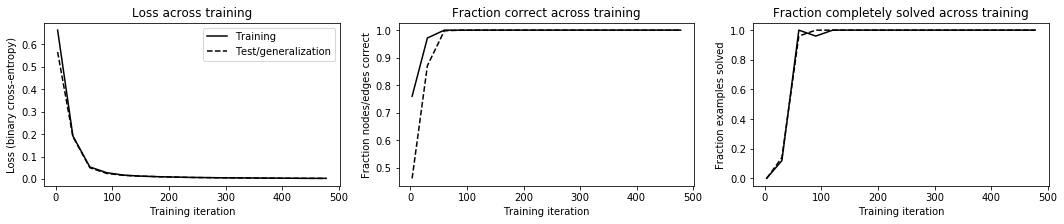

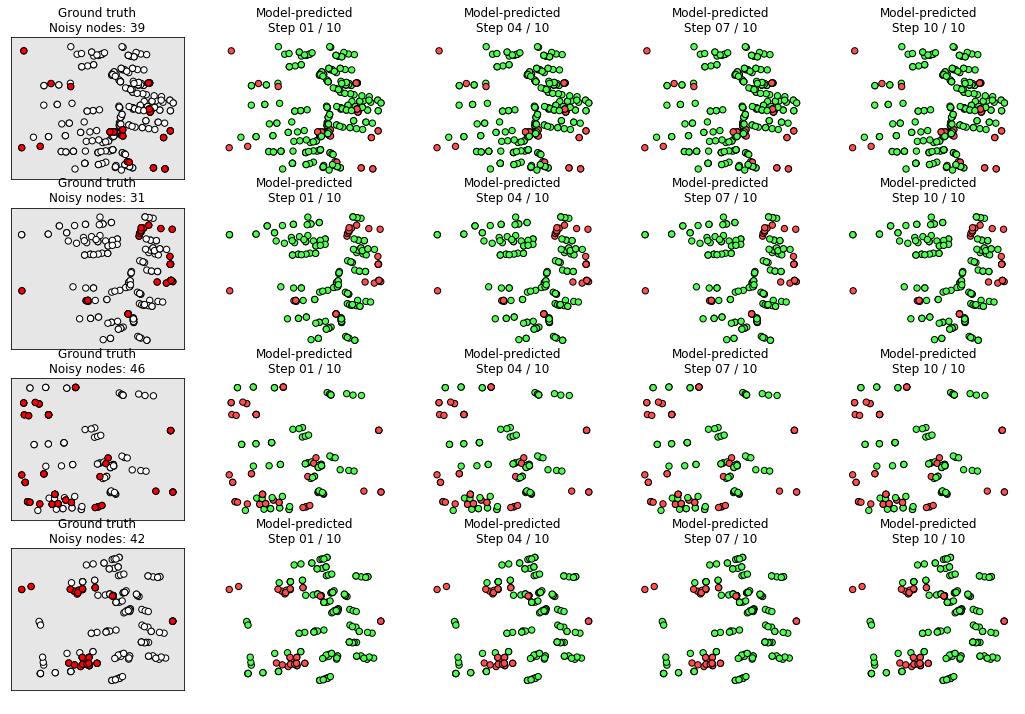

In [8]:
#@title Visualize results

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.


def softmax_prob_last_dim(x):
    e = np.exp(x)
    return e[:, -1] / np.sum(e, axis=-1)


# Plot results curves.
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction completely solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")



# Plot graphs and results after each processing step.
# Predicted noisy nodes are colored
# from red to yellow to green, where red means the model is confident the node is
# noisy, green means the model is confident the node is NOT noisy,
# and yellowish colors mean the model isn't sure.

max_graphs_to_plot = 4
num_steps_to_plot = 4
node_size = 40
min_c = 0.3
targets = utils_np.graphs_tuple_to_networkxs(test_values["target"])
inputs = utils_np.graphs_tuple_to_networkxs(test_values["inputs"])
step_indices = np.floor(
    np.linspace(0, num_processing_steps - 1,
                num_steps_to_plot)).astype(int).tolist()
outputs = list(
    zip(*(utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
          for i in step_indices)))
h = max_graphs_to_plot
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (target, inp, output) in enumerate(zip(targets, inputs, outputs)):
    if j >= h:
        break
    # Ground truth.
    iax = j * (1 + num_steps_to_plot) + 1
    ax = fig.add_subplot(h, w, iax)
    pos = get_node_pos(inp)    
    plotter = GraphPlotter(ax, target, pos)
    plotter.draw_graph_with_noise(node_size=node_size)
    ax.set_axis_on()
    ax.set_xticks([])
    ax.set_yticks([])
    try:
        ax.set_facecolor([0.9] * 3 + [1.0])
    except AttributeError:
        ax.set_axis_bgcolor([0.9] * 3 + [1.0])
    ax.grid(None)
    ax.set_title("Ground truth\nNoisy nodes: {}".format(
        plotter.noisy_nodes_count))
    # Prediction.
    for k, outp in enumerate(output):
        iax = j * (1 + num_steps_to_plot) + 2 + k
        ax = fig.add_subplot(h, w, iax)
        plotter = GraphPlotter(ax, target, pos)
        color = {}
        prob = softmax_prob_last_dim(outp["nodes"])
        for i, n in enumerate(plotter.nodes):
            color[n] = np.array([prob[n], 1.0 - prob[n], 0.0, 1.0
                                 ]) * (1.0 - min_c) + min_c
        plotter.draw_graph_with_noise(node_size=node_size, node_color=color, draw_noisy_nodes=False)
        ax.set_title("Model-predicted\nStep {:02d} / {:02d}".format(
            step_indices[k] + 1, step_indices[-1] + 1))